In [1403]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.preprocessing
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [1404]:
df = pd.read_csv('../dataset_diabetes/diabetic_data.csv')
# check missing values
df = df.replace('?',np.nan)
# df[df.columns].isnull().sum() 
# df.info()
print(len(df))

101766


In [1405]:
# remove impatient visit
df = df.groupby('patient_nbr').first()
print(len(df))

71518


In [1406]:
# remove sample about death or hospic
df = df.loc[~df['discharge_disposition_id'].isin([11,13,14,19,20,21])]
print(len(df))

69973


In [1407]:
# no unique values in each feature
for c in list(df.columns[:]):
    d = df[c]
    n = d.unique()
    print('Feature and unique values: ' + c + ', ' +str(len(n)) + ', ' + str(d.dtypes))

Feature and unique values: encounter_id, 69973, int64
Feature and unique values: race, 6, object
Feature and unique values: gender, 3, object
Feature and unique values: age, 10, object
Feature and unique values: weight, 10, object
Feature and unique values: admission_type_id, 8, int64
Feature and unique values: discharge_disposition_id, 21, int64
Feature and unique values: admission_source_id, 17, int64
Feature and unique values: time_in_hospital, 14, int64
Feature and unique values: payer_code, 18, object
Feature and unique values: medical_specialty, 71, object
Feature and unique values: num_lab_procedures, 116, int64
Feature and unique values: num_procedures, 7, int64
Feature and unique values: num_medications, 75, int64
Feature and unique values: number_outpatient, 33, int64
Feature and unique values: number_emergency, 18, int64
Feature and unique values: number_inpatient, 13, int64
Feature and unique values: diag_1, 695, object
Feature and unique values: diag_2, 724, object
Feature

In [1412]:
# convert Categorial value into numerical value
labelencoder = sklearn.preprocessing.LabelEncoder()
for c in list(df.columns[1:]):
    d = df[c]
    if d.dtypes == 'object':
        if d.isnull().sum() == 0:     # if No missing value and Object
            if len(d.unique()) < 40:  # if 
                df[c] = labelencoder.fit_transform(d)
            else:
                de = labelencoder.fit_transform(d)
                dc = pd.cut(de, 40)
                df[c] = labelencoder.fit_transform(dc)       
        else:  # If missing value and Object
            if len(d.unique()) < 40:   
                df[c] = d.fillna(str(0))
                df[c] = labelencoder.fit_transform(d)
            else:
                de = d.fillna(str(0))
                de = labelencoder.fit_transform(de)
                dc = pd.cut(de, 40)
                df[c] = labelencoder.fit_transform(dc)
    else:
        if d.isnull().sum() == 0:     # if No missing value 
            if len(d.unique()) > 40:  #  
                dc = pd.cut(de, 40)
                df[c] = labelencoder.fit_transform(dc)       
        else:  # If missing value
            if len(d.unique()) > 40:
                dc = pd.cut(de, 40)
                df[c] = labelencoder.fit_transform(dc)
df.head()

,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,24437208,3,0,5,0,2,1,1,8,0,...,0,2,1,0,0,0,0,0,1,0
378,29758806,3,0,5,0,3,1,1,2,0,...,0,1,1,0,0,0,0,1,0,2
729,189899286,3,0,8,0,1,3,7,4,8,...,0,1,1,0,0,0,0,1,1,2
774,64331490,3,0,8,0,1,1,7,3,0,...,0,1,1,0,0,0,0,0,1,2
927,14824206,1,0,3,0,1,1,7,5,0,...,0,1,1,0,0,0,0,1,1,2


In [1413]:
df['readmitted'].value_counts()

2    41474
1    22222
0     6277
Name: readmitted, dtype: int64

In [1414]:
# remsample to make data balance
from sklearn.utils import resample
df_0 = df[df.readmitted==0]
df_1 = df[df.readmitted==1]
df_2 = df[df.readmitted==2]
no_sample_0 = int(0.9*len(df_2))
no_sample_1 = int(0.9*len(df_2))

df_0_upsampled = resample(df_0,
                          replace=True,     
                          n_samples=no_sample_0,  
                          random_state=123) 

df_1_upsampled = resample(df_1,
                          replace=True,   
                          n_samples=no_sample_1,  
                          random_state=123) 

df_2_upsampled = resample(df_2,
                          replace=True,     
                          n_samples=len(df_1),  
                          random_state=123) 

df_upsampled = pd.concat([df_0_upsampled, df_1_upsampled, df_2])  # Oversample
# df_upsampled = pd.concat([df_0, df_1, df_2_upsampled])  # Undersample
df_upsampled['readmitted'].value_counts()

2    41474
1    37326
0    37326
Name: readmitted, dtype: int64

In [1415]:
# K-fold Cross Validation to find best parameter for models
from sklearn.model_selection import GridSearchCV, cross_val_score
def k_Fold_CV(x, y):
    param_grid_rdf = {'n_estimators': [50, 100]}
    param_grid_lg = {'multi_class': ['multinomial'], 'solver':['newton-cg', 'sag', 'saga','lbfgs']}

    models = [('LG', LogisticRegression(), param_grid_lg), ('RDF', RandomForestClassifier(), param_grid_rdf)]
    best_cv_score = []
    mean_cv_score = []

    for name, model, param_grid in models:
        grid_cv = GridSearchCV(model, param_grid, cv=5).fit(x, y)
        print("Best parameters for : ", name, " is ", grid_cv.best_params_)
        print("%.1f%% accuracy on validation sets (average)" % (grid_cv.best_score_*100))
        best_cv_score.append(grid_cv.best_score_)
        ac_score = cross_val_score(model, x, y, cv=5, scoring='accuracy')
        mean_cv_score.append(ac_score.mean())
    return best_cv_score, mean_cv_score


In [1416]:
def model_logistic(X_train, X_test, y_train, y_test):
    model = LogisticRegression(multi_class='multinomial',solver ='newton-cg').fit(X_train,y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    return model, accuracy_train, accuracy_test

In [1417]:
def model_randomForest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, max_depth = 20).fit(X_train,y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    return model, accuracy_train, accuracy_test

In [1418]:
# Featuer importace plot for logistic regerssion
def plot_importance_lg(model, features):
    feature_importances = pd.DataFrame(model.coef_[0]+model.coef_[1], 
                                       index = features, columns=['importance']).sort_values('importance', ascending=False)
    num = len(feature_importances)
    ylocs = np.arange(num)
    values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
    feature_labels = list(feature_importances.iloc[:num].index)[::-1]

    plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
    plt.barh(ylocs, values_to_plot, align = 'center')
    plt.ylabel('Features')
    plt.xlabel('Importance Score')
    plt.title('Feature Importance Score - Logistic Regression')
    plt.yticks(ylocs, feature_labels)
    plt.show()

In [1419]:
# Featuer importace plot for Randdom Forest
def plot_importance_rdf(model, features):
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = features,columns=['importance']).sort_values('importance',ascending=False)
    num = len(feature_importances)
    ylocs = np.arange(num)
    values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
    feature_labels = list(feature_importances.iloc[:num].index)[::-1]

    plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
    plt.barh(ylocs, values_to_plot, align = 'center')
    plt.ylabel('Features')
    plt.xlabel('Importance Score')
    plt.title('Feature Importance Score - RandomForest')
    plt.yticks(ylocs, feature_labels)
    plt.show()

In [1420]:
def plot_correlation_matrix(data):
    corrMatrix = data.corr()
    sn.heatmap(corrMatrix, annot=True)
    plt.show()

In [1421]:
# calculate accurecy
def calculate_accurecy(y_true, y_pred):   
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    F1 = 2*(precision*recall)/(precision+recall)
    
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('F1:%.3f'%F1)
    return accuracy, recall, precision, F1

In [1439]:
# feature 
features = ['race', 'gender', 'age', 'admission_type_id',
            'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
            'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
            'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
            'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
            'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
            'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
            'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
            'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

## without resample
X = df[features]
y = df['readmitted']

## with resample
# X = df_upsampled[features]
# y = df_upsampled['readmitted']

## Data split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
## Data scaling
scaler = sklearn.preprocessing.StandardScaler()
# scaler = sklearn.preprocessing.RobustScaler()
# scaler = sklearn.preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train.value_counts()

2    29064
1    15530
0     4387
Name: readmitted, dtype: int64

In [1427]:
# K-fold cross validation-check
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=ConvergenceWarning)
simplefilter(action='ignore', category=FutureWarning)

k_Fold_CV(scaler.fit_transform(X), y)

Best parameters for :  LG  is  {'multi_class': 'multinomial', 'solver': 'newton-cg'}
59.5% accuracy on validation sets (average)
Best parameters for :  RDF  is  {'n_estimators': 100}
57.9% accuracy on validation sets (average)


([0.5953867920483615, 0.5793806182384634],
 [0.5946155758637666, 0.5376785510941701])

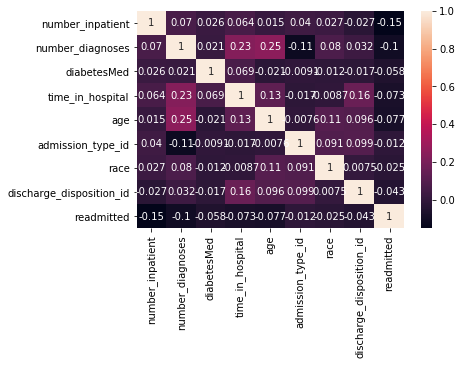

In [1428]:
cor_fe = ['number_inpatient', 'number_diagnoses', 'diabetesMed', 'time_in_hospital', 
          'age', 'admission_type_id', 'race', 'discharge_disposition_id', 'readmitted']
plot_correlation_matrix(df[cor_fe])

In [1429]:
model_lg, accuracy_train, accuracy_test = model_logistic(X_train, X_test, y_train, y_test)
print(accuracy_train, accuracy_test)

0.6019068618443887 0.5997522865853658


In [1430]:
# Training Error for LG
y_pred = model_lg.predict(X_train)
calculate_accurecy(y_train, y_pred)

accuracy:0.602
recall:0.602
precision:0.545
F1:0.572


(0.6019068618443887,
 0.6019068618443887,
 0.5447556496831395,
 0.5719070088651937)

In [1431]:
# Test Error for LG
y_pred = model_lg.predict(X_test)
calculate_accurecy(y_test, y_pred)

accuracy:0.600
recall:0.600
precision:0.546
F1:0.572


(0.5997522865853658,
 0.5997522865853658,
 0.5462851998687357,
 0.5717715199050594)

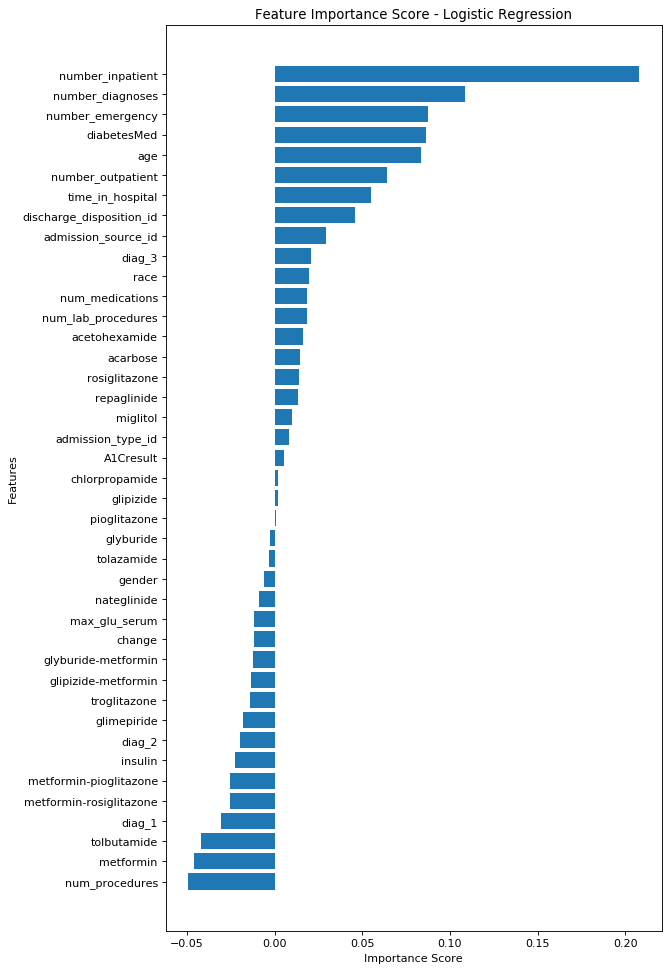

In [1432]:
plot_importance_lg(model_lg, features)

In [1440]:
model_rdf, accuracy_train, accuracy_test = model_randomForest(X_train, X_test, y_train, y_test)
print(accuracy_train, accuracy_test)

0.8554949878524326 0.6068025914634146


In [1441]:
# Training Error
y_pred = model_rdf.predict(X_train)
calculate_accurecy(y_train, y_pred)

accuracy:0.855
recall:0.855
precision:0.882
F1:0.869


(0.8554949878524326, 0.8554949878524326, 0.8824906327789388, 0.868783152411631)

In [1442]:
# Test Error
y_pred = model_rdf.predict(X_test)
calculate_accurecy(y_test, y_pred)

accuracy:0.607
recall:0.607
precision:0.549
F1:0.576


(0.6068025914634146,
 0.6068025914634146,
 0.5488248598440202,
 0.5763593567046552)

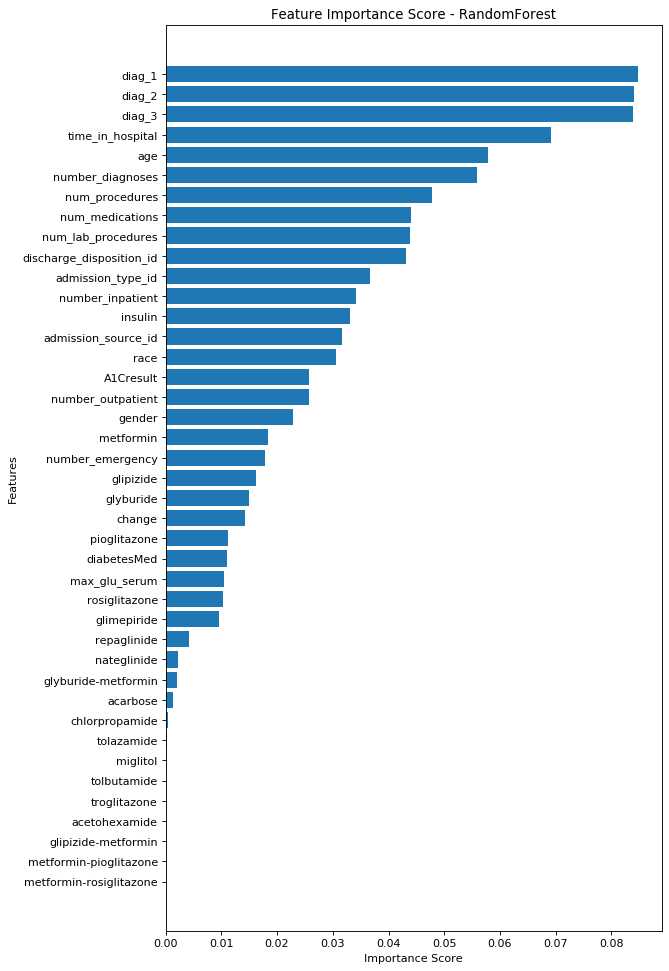

In [1443]:
plot_importance_rdf(model_rdf, features)

In [1279]:
# we can break important feature and can see groups of vales are more imprortant
add_new_feature = pd.get_dummies(df['number_inpatient'], drop_first = False, prefix='number_inpatient')

old_features = ['race', 'gender', 'age','admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

df_new = pd.concat([df[old_features], add_new_feature], axis = 1)
X_new = df_new
y_new = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=0)
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train.value_counts()

2    29064
1    15530
0     4387
Name: readmitted, dtype: int64

In [1280]:
model_lg_new, accuracy_train, accuracy_test = model_logistic(X_train, X_test, y_train, y_test)
print(accuracy_train, accuracy_test)

0.6024376799167024 0.6016577743902439


In [1281]:
y_pred = model_lg_new.predict(X_train)
calculate_accurecy(y_train, y_pred)

accuracy:0.602
recall:0.602
precision:0.558
F1:0.579


(0.6024376799167024, 0.6024376799167024, 0.5579637330750837, 0.579348444543466)

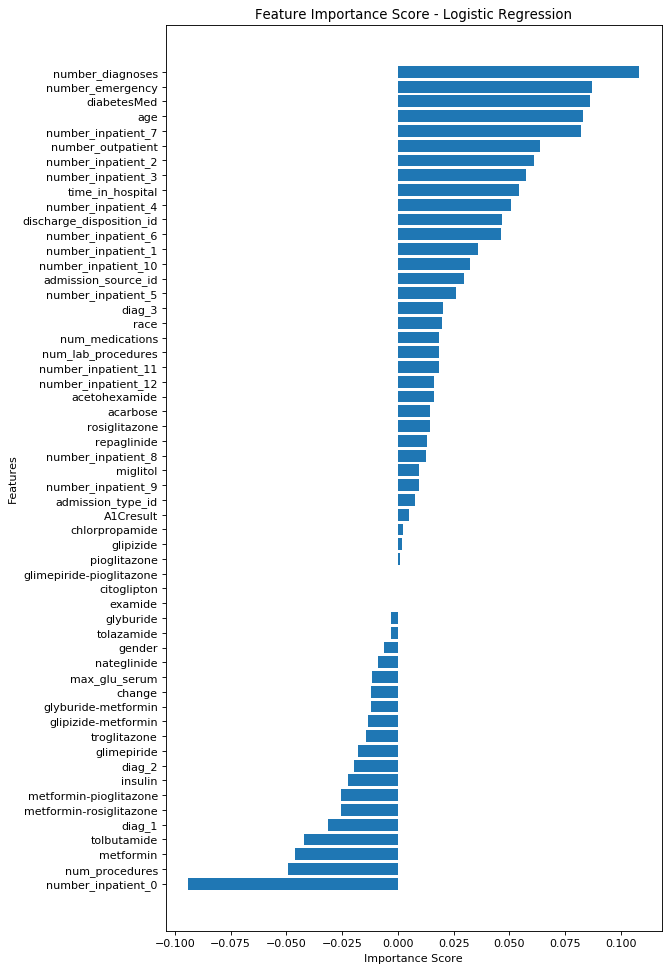

In [1282]:
plot_importance_lg(model_lg_new, df_new.columns)

In [1283]:
model_rdf_new, accuracy_train, accuracy_test = model_randomForest(X_train, X_test, y_train, y_test)
print(accuracy_train, accuracy_test)

0.9998775035217737 0.6048971036585366


In [1284]:
y_pred = model_rdf_new.predict(X_train)
calculate_accurecy(y_train, y_pred)

accuracy:1.000
recall:1.000
precision:1.000
F1:1.000


(0.9998775035217737,
 0.9998775035217737,
 0.9998775060604325,
 0.9998775047911032)

In [1286]:
y_pred = model_rdf_new.predict(X_test)
calculate_accurecy(y_test, y_pred)

accuracy:0.605
recall:0.605
precision:0.561
F1:0.582


(0.6048971036585366,
 0.6048971036585366,
 0.5610226406131291,
 0.5821343571220505)

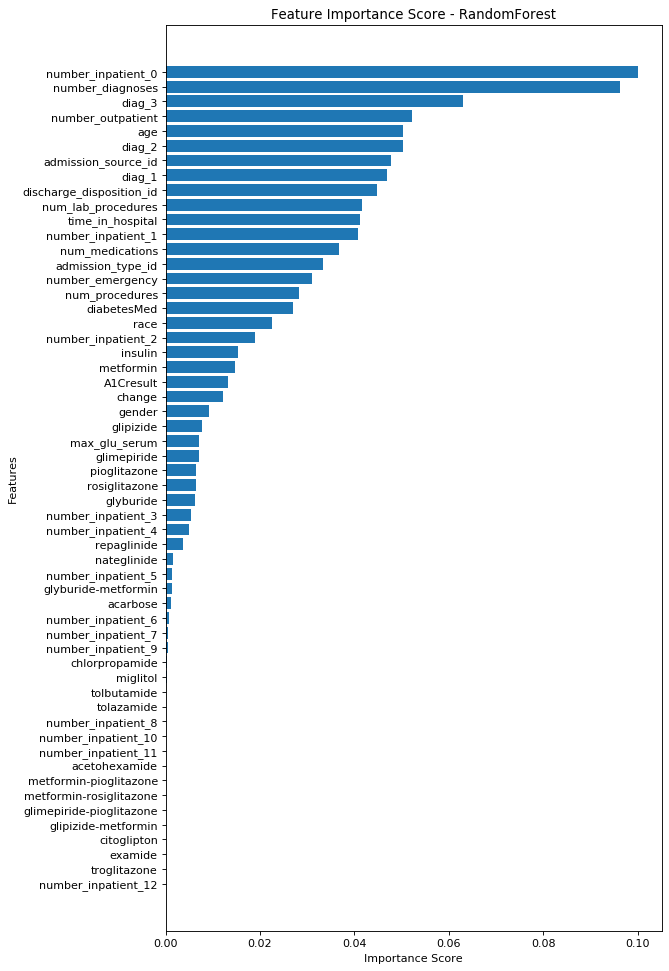

In [1214]:
plot_importance_rdf(model_rdf_new, df_new.columns)